In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from dmba import classificationSummary, gainsChart, liftChart
import matplotlib.pylab as plt

In [2]:
delay_df = pd.read_csv('FlightDelays.csv') 
delay_df = delay_df.rename(columns={'Weather': 'WEATHER','Flight Status': 'FLIGHT_STATUS'})
delay_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,WEATHER,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,FLIGHT_STATUS
0,1455,OH,1455,JFK,184,01-01-2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01-01-2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01-01-2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01-01-2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01-01-2004,7792,IAD,0,4,1,N698BR,ontime


##### Since tail number and flight number are used only for identification of the flights, we can say that the tail number and the flight number does not impact the status of a flight. So, we will exclude them from further analysis.

##### From a little research on the factors causing flight delays. flight date and the day of the month do not cause any noticeable impact on the flight status. As a result, we will remove these two variables from our list of predictors.

##### If we know both the origin and destination, then the distance becomes redundant since it can be found out from knowing the origin and destination. So, we will exclude distance from further analysis.

In [3]:
delay_df = delay_df.drop(['FL_DATE', 'DAY_OF_MONTH', 'FL_NUM','TAIL_NUM','DISTANCE'], axis = 1)
delay_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,ORIGIN,WEATHER,DAY_WEEK,FLIGHT_STATUS
0,1455,OH,1455,JFK,BWI,0,4,ontime
1,1640,DH,1640,JFK,DCA,0,4,ontime
2,1245,DH,1245,LGA,IAD,0,4,ontime
3,1715,DH,1709,LGA,IAD,0,4,ontime
4,1039,DH,1035,LGA,IAD,0,4,ontime


In [4]:
corrMatrix = delay_df.corr()
corrMatrix

,CRS_DEP_TIME,DEP_TIME,WEATHER,DAY_WEEK
CRS_DEP_TIME,1.000000,0.983523,-0.008266,0.051766
DEP_TIME,0.983523,1.000000,0.019001,0.051868
WEATHER,-0.008266,0.019001,1.000000,-0.123636
DAY_WEEK,0.051766,0.051868,-0.123636,1.000000


### Since there is a very high correlation between CRS_DEP_TIME and DEP_TIME, we will eliminate one of it, and it is DEP_TIME

In [5]:
delay_df = delay_df.drop(['DEP_TIME'], axis = 1)
delay_df.to_csv('FlightDelaysTrainingData.csv', index = False)

### Preparing the data for exploration using pivot tables

In [6]:
data_explore_1 = delay_df
predictors = list(data_explore_1.columns)[0:7]
data_explore = pd.get_dummies(data_explore_1[predictors], drop_first = False)
data_explore['FLIGHT_STATUS'] = data_explore_1['FLIGHT_STATUS']
data_explore['CARRIER'] = data_explore_1['CARRIER']
data_explore['DEST'] = data_explore_1['DEST']
data_explore['ORIGIN'] = data_explore_1['ORIGIN']
data_explore.to_csv('FlightDelaysDataExploration.csv', index = False)

### Number of flights delayed and ontime, grouped by the day of the week.

In [7]:
data_explore.pivot_table(index = ['DAY_WEEK'], values = ['FLIGHT_STATUS_delayed','FLIGHT_STATUS_ontime'], aggfunc = np.sum)

,FLIGHT_STATUS_delayed,FLIGHT_STATUS_ontime
DAY_WEEK,,
1,84,224.0
2,63,244.0
3,57,263.0
4,57,315.0
5,75,316.0
6,24,226.0
7,68,185.0


### Proportion of the flights delayed and ontime, grouped by the carriers

In [8]:
data_explore.pivot_table(index = ['CARRIER'],  values = ['FLIGHT_STATUS_delayed','FLIGHT_STATUS_ontime'], aggfunc = np.mean)

,FLIGHT_STATUS_delayed,FLIGHT_STATUS_ontime
CARRIER,,
CO,0.276596,0.723404
DH,0.248639,0.751361
DL,0.121134,0.878866
MQ,0.271186,0.728814
OH,0.133333,0.866667
RU,0.230392,0.769608
UA,0.161290,0.838710
US,0.086634,0.913366


### Number of flight delays due to the impact of weather at origins and destinations

In [9]:
data_explore.pivot_table(index = ['FLIGHT_STATUS', 'WEATHER'],  values = ['ORIGIN_BWI','ORIGIN_DCA','ORIGIN_IAD','DEST_JFK','DEST_EWR','DEST_LGA'], aggfunc = np.sum)

DEST_EWR  DEST_JFK  DEST_LGA  ORIGIN_BWI  ORIGIN_DCA  \
FLIGHT_STATUS WEATHER                                                         
delayed       0           153.0      76.0     167.0          36       204.0   
              1             8.0       8.0      16.0           1        17.0   
ontime        0           504.0     302.0     967.0         108      1149.0   

                       ORIGIN_IAD  
FLIGHT_STATUS WEATHER              
delayed       0             156.0  
              1              14.0  
ontime        0             516.0

### Finding the route that has the most delays

In [10]:
data_explore.pivot_table(index = ['ORIGIN'], columns = ['DEST'], values = ['FLIGHT_STATUS_delayed','FLIGHT_STATUS_ontime'], aggfunc = np.sum)

FLIGHT_STATUS_delayed              FLIGHT_STATUS_ontime              
DEST                     EWR   JFK    LGA                  EWR    JFK    LGA
ORIGIN                                                                      
BWI                     33.0   4.0    NaN                 82.0   26.0    NaN
DCA                     54.0  40.0  127.0                202.0  109.0  838.0
IAD                     74.0  40.0   56.0                220.0  167.0  129.0

In [11]:
delay_df.DAY_WEEK = delay_df.DAY_WEEK.astype('category')
delay_df.WEATHER = delay_df.WEATHER.astype('category')

delay_df.CRS_DEP_TIME = [round(t/100) for t in delay_df.CRS_DEP_TIME]
delay_df.CRS_DEP_TIME = delay_df.CRS_DEP_TIME.astype('category')

In [12]:
predictors = list(delay_df.columns)[0:6]
X = pd.get_dummies(delay_df[predictors])
y = delay_df['FLIGHT_STATUS']
classes = ['ontime', 'delayed']

In [13]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

## Naive Bayes Model

In [14]:
delays_nb = MultinomialNB(alpha=0.8)
delays_nb.fit(train_X,train_y)

MultinomialNB(alpha=0.8)

In [15]:
classificationSummary(train_y, delays_nb.predict(train_X))

Confusion Matrix (Accuracy 0.8076)

       Prediction
Actual    0    1
     0   54  207
     1   47 1012


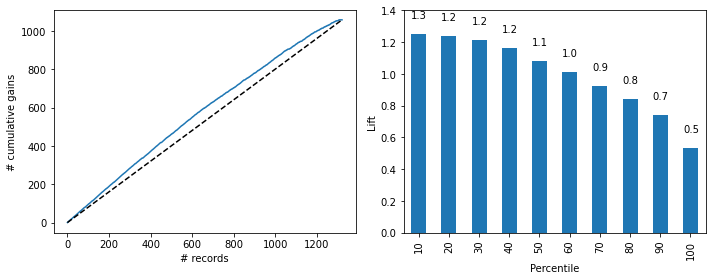

In [16]:
delays_nb_pred = delays_nb.predict(train_X)
delays_nb_proba = delays_nb.predict_proba(train_X)
delays_nb_result = pd.DataFrame ({'actual': train_y ,
                              'p(0)': [p[0] for p in delays_nb_proba],
                              'p(1)': [p[1] for p in delays_nb_proba],
                              'predicted': delays_nb_pred })

df = delays_nb_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

In [17]:
classificationSummary(valid_y, delays_nb.predict(valid_X))

Confusion Matrix (Accuracy 0.8127)

       Prediction
Actual   0   1
     0  41 126
     1  39 675


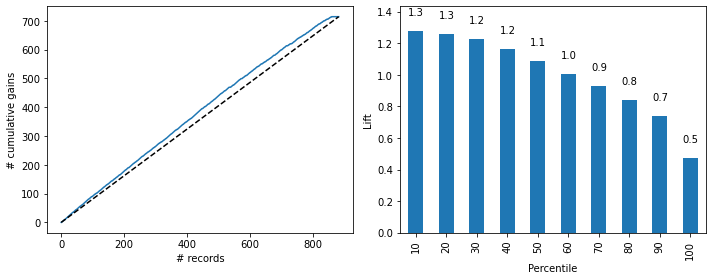

In [18]:
delays_nb_pred = delays_nb.predict(valid_X)
delays_nb_proba = delays_nb.predict_proba(valid_X)
delays_nb_result = pd.DataFrame ({'actual': valid_y ,
                              'p(0)': [p[0] for p in delays_nb_proba],
                              'p(1)': [p[1] for p in delays_nb_proba],
                              'predicted': delays_nb_pred })

df = delays_nb_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

## CART Model

In [19]:
classTree = DecisionTreeClassifier()
classTree.fit(train_X,train_y)

DecisionTreeClassifier()

In [20]:
classificationSummary(train_y, classTree.predict(train_X))

Confusion Matrix (Accuracy 0.8727)

       Prediction
Actual   0   1
     0 179  82
     1  86 973


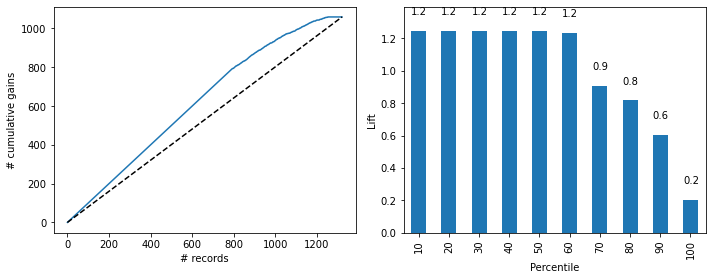

In [21]:
classTree_pred = classTree.predict(train_X)
classTree_proba = classTree.predict_proba(train_X)
classTree_result = pd.DataFrame ({'actual': train_y ,
                              'p(0)': [p[0] for p in classTree_proba],
                              'p(1)': [p[1] for p in classTree_proba],
                              'predicted': classTree_pred })

df = classTree_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

In [22]:
classificationSummary(valid_y, classTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7072)

       Prediction
Actual   0   1
     0  61 106
     1 152 562


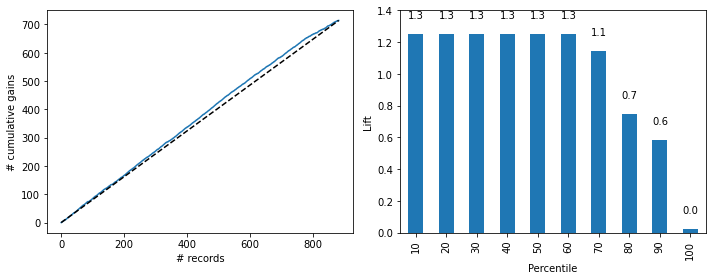

In [23]:
classTree_pred = classTree.predict(valid_X)
classTree_proba = classTree.predict_proba(valid_X)
classTree_result = pd.DataFrame ({'actual': valid_y ,
                              'p(0)': [p[0] for p in classTree_proba],
                              'p(1)': [p[1] for p in classTree_proba],
                              'predicted': classTree_pred })

df = classTree_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

## Logistic Regression

In [24]:
logit_reg = LogisticRegression(C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [25]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.8144)

       Prediction
Actual    0    1
     0   31  230
     1   15 1044


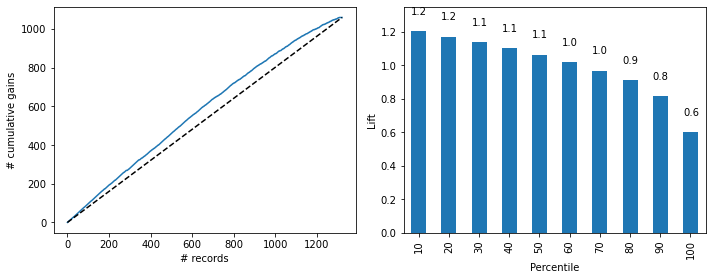

In [26]:
logit_reg_pred = logit_reg.predict(train_X)
logit_reg_proba = logit_reg.predict_proba(train_X)
logit_result = pd.DataFrame ({'actual': train_y ,
                              'p(0)': [p[0] for p in logit_reg_proba],
                              'p(1)': [p[1] for p in logit_reg_proba],
                              'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

In [27]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8309)

       Prediction
Actual   0   1
     0  27 140
     1   9 705


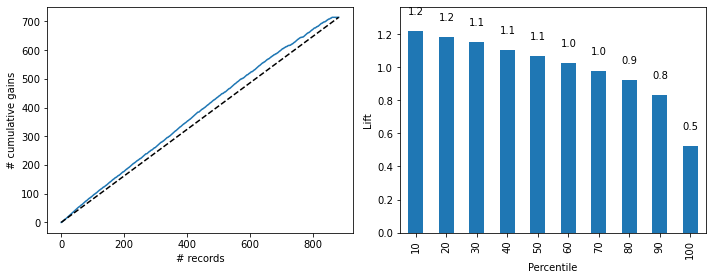

In [28]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame ({'actual': valid_y ,
                              'p(0)': [p[0] for p in logit_reg_proba],
                              'p(1)': [p[1] for p in logit_reg_proba],
                              'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
df = pd.get_dummies(df, drop_first = True)
fig, axes = plt.subplots(nrows=1 , ncols=2 , figsize=(10 , 4))
gainsChart(df.actual_ontime , ax= axes[0])
liftChart(df['p(1)'], title=False, ax= axes[1])
plt.tight_layout()
plt.show()

Creating Test dataset

In [29]:
CRS_DEP_TIME = [1655,1825,1430,1115,1345]
CARRIER = ["MQ","US","OH","DL","DH"]
DEST = ["JFK","LGA","JFK","EWR","LGA"]
ORIGIN = ["DCA","IAD","BWI","IAD","DCA"]
WEATHER = [0,1,0,1,1]
DAY_WEEK = [5,3,1,7,1]

diction = {'CRS_DEP_TIME':CRS_DEP_TIME, 'CARRIER':CARRIER, 'DEST':DEST, 'ORIGIN':ORIGIN, 'WEATHER':WEATHER, 'DAY_WEEK':DAY_WEEK}
test_data = pd.DataFrame(diction)

In [30]:
test_data.to_csv('FlightDelaysTestingData.csv', index = False)

test_data.DAY_WEEK = test_data.DAY_WEEK.astype('category')
test_data.WEATHER = test_data.WEATHER.astype('category')

test_data.CRS_DEP_TIME = [round(t/100) for t in test_data.CRS_DEP_TIME]
test_data.CRS_DEP_TIME = test_data.CRS_DEP_TIME.astype('category')

In [31]:
test_X = pd.get_dummies(test_data)
empty_df = pd.DataFrame(columns = X.columns)

test_X = pd.concat([empty_df,test_X],ignore_index=True).fillna(0)

In [32]:
flight_status = logit_reg.predict(test_X)

test_data['PREDICTED_FLIGHT_STATUS'] = flight_status
test_data.to_csv('FlightDelaysTestingData.csv', index = False)